# 1. Imports


1. Verify hd-bet works for PET images (try with and without skull)
     -> If not look at bet2
   
3. Try in Native space rather than MNI space
   
4. Try ADC if available

5. Expand Dataset
   
     -> Check unprocessed data, ADNI data (possibly ADNI for validation later)

6. Read literature and try different architectures
   
    -> Log metrics on test set after each experiment
        (SSIM, MSE, Inception score)

If use department GPU, make sure don't hog resources (esp if running overnight)

In [1]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import AHNet
from tqdm import tqdm
import monai
from monai.utils import progress_bar
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    RandFlipd,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd,
    NormalizeIntensityd
)
from monai.losses.ssim_loss import SSIMLoss
import statistics

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3"

In [3]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

In [4]:
# global variables
image_size = (128,128,64)

# 2. MONAI Dataloader

In [5]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,image_size[0],image_size[1],image_size[2]))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,image_size[0],image_size[1],image_size[2]))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image (not being used rn)
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["t1", "t1c", "t2", "flair", "pet"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Orientationd(keys=["t1", "t1c", "t2", "flair", "pet"], axcodes="RAS"),        
        EnsureTyped(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Resized(keys=["t1", "t1c", "t2", "flair", "pet"], spatial_size=image_size),
        MakeSingleVolumed(keys=["t1", "t1c", "t2", "flair", "pet"]),
        Rotate90d(keys=["t1", "t1c", "t2", "flair", "pet"]),
        ScaleIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        NormalizeIntensityd(keys=["t1", "t1c", "t2", "flair", "pet"]),
        RandFlipd(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.5, spatial_axis=1),
        RandRotated(keys=["t1", "t1c", "t2", "flair", "pet"], prob=0.6, range_z=0.3)
    ]
)

In [7]:
val_files = dictionary_train[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

It has been 19.339435577392578 seconds since the loop started


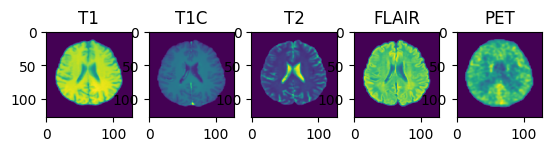

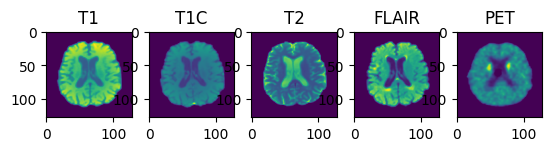

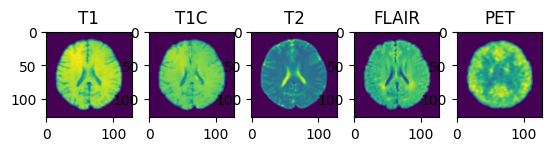

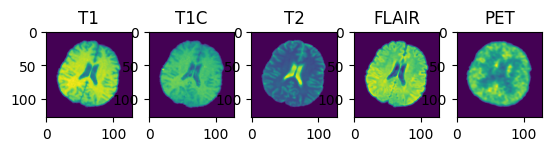

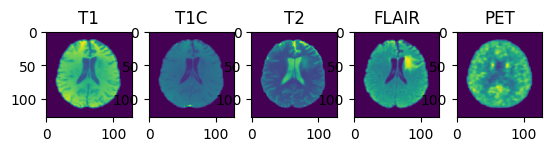

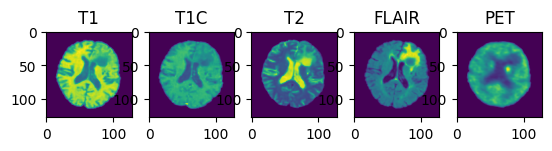

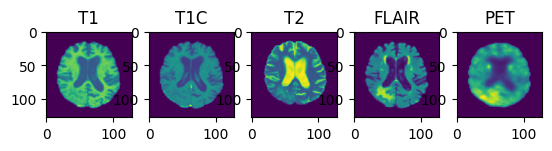

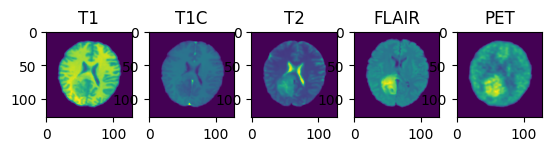

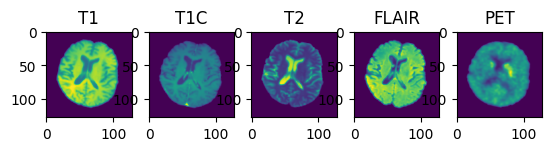

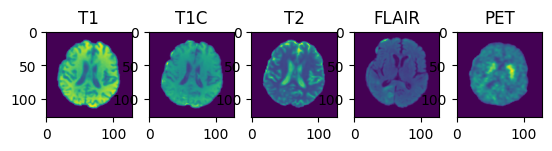

In [8]:
program_starts = time()
step = 1350
slice_index = 32
for item in check_DataLoader:
    image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index]
    
    f, axarr = plt.subplots(1, 5)
    
    axarr[0].imshow(image_datas[0])
    axarr[0].set_title("T1")
    axarr[1].imshow(image_datas[1])
    axarr[1].set_title("T1C")
    axarr[2].imshow(image_datas[2])
    axarr[2].set_title("T2")
    axarr[3].imshow(image_datas[3])
    axarr[3].set_title("FLAIR")
    axarr[4].imshow(image_datas[4])
    axarr[4].set_title("PET")
    
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

In [9]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=os.cpu_count(), drop_last=False)

train_metric_ds = CacheDataset(data=dictionary_train[:10], transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_metric_loader = DataLoader(train_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=os.cpu_count())

80


Loading dataset: 100%|██████████████████████████| 57/57 [00:39<00:00,  1.43it/s]


# 3. Model Setup


In [14]:
class GLA_Generator(nn.Module):
    def __init__(self):
        super(GLA_Generator, self).__init__()
        self.ahnet_global = AHNet(spatial_dims=3, in_channels=4, out_channels=16, pretrained=True)

        channels = [4, 6, 12, 6, 4]
        strides = [1, 1, 1, 1, 1]
        
        self.ahnet_1 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_2 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_3 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)
        self.ahnet_4 = monai.networks.nets.AttentionUnet(spatial_dims=3, in_channels=4, out_channels=16, channels=channels, strides=strides)

        self.conv1 = nn.Conv3d(32, 16, kernel_size=1)
        self.bn1 = nn.BatchNorm3d(16)
        self.relu = nn.ReLU()
        #self.dropout = torch.nn.Dropout(0)
        self.conv2 = nn.Conv3d(16, 1, kernel_size=1)
        self.bn2 = nn.BatchNorm3d(1)

    def forward(self, x):
        batch_size, channels, width, height, depth = x.shape
        half_width, half_height = width // 2, height // 2
        
        # Splitting the input into 4 patches
        patch_1 = x[:, :, :half_width, :half_height, :]
        patch_2 = x[:, :, :half_width, half_height:, :]
        patch_3 = x[:, :, half_width:, :half_height, :]
        patch_4 = x[:, :, half_width:, half_height:, :]

        x = self.ahnet_global(x)
        patch_1 = self.ahnet_1(patch_1)
        patch_2 = self.ahnet_2(patch_2)
        patch_3 = self.ahnet_3(patch_3)
        patch_4 = self.ahnet_4(patch_4)

        # Concatenating the processed patches
        top_row = torch.cat([patch_1, patch_2], dim=3)  # Concatenate along the height
        bottom_row = torch.cat([patch_3, patch_4], dim=3)  # Concatenate along the height
        concatenated_patches = torch.cat([top_row, bottom_row], dim=2)  # Concatenate along the width

        x = torch.cat([x, concatenated_patches], dim=1)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #x = self.dropout(x)
        x = self.conv2(x)
        x = self.bn2(x)

        return x

### 3.1 Model and Device Setup

In [15]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

gen_net = GLA_Generator()

disc_net = monai.networks.nets.Critic(
    in_shape=(128, 128, 64),
    channels=(8, 16, 32, 64, 1),
    strides=(2, 2, 2, 2, 1),
    num_res_units=2,
    kernel_size=3,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    gen_net = nn.DataParallel(gen_net)
    disc_net = nn.DataParallel(disc_net)

gen_net.to(device)
disc_net.to(device)

real_label = 1
gen_label = 0

disc_loss = torch.nn.BCELoss()
gen_loss = torch.nn.BCELoss()
gen_loss2 = monai.metrics.MultiScaleSSIMMetric(spatial_dims=3, kernel_size=4)

disc_opt = torch.optim.Adam(disc_net.parameters(), 0.0001)
gen_opt = torch.optim.Adam(gen_net.parameters(), 0.0001)

def discriminator_loss(fake_pred, real_pred, gp, c_lambda):
    """
    The discriminator loss if calculated by comparing its
    prediction for real and generated images.

    """
    return torch.mean(fake_pred) - torch.mean(real_pred) + c_lambda * gp


def generator_loss(input, real_images):
    """
    The generator loss is calculated by determining how well
    the discriminator was fooled by the generated images.

    """
    ssim = 1 - torch.mean(gen_loss2(input, real_images))
    fake_pred = disc_net(input[:,0,:,:,:])
    
    return (-1*torch.mean(fake_pred)) + ssim

cuda
Let's use 3 GPUs!


In [16]:
def get_gradient(crit, real, fake, epsilon):

    mixed_images = real * epsilon + fake * (1 - epsilon)

    mixed_scores = crit(mixed_images)
    
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
        
    )[0]
    return gradient

def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)

    gradient_norm = gradient.norm(2, dim=1)
    
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

### 3.2 Training


----------
epoch 1/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:24<00:00,  6.03s/it]


----------
epoch 2/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:17<00:00,  5.71s/it]


----------
epoch 3/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:17<00:00,  5.72s/it]


----------
epoch 4/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:20<00:00,  5.87s/it]


----------
epoch 5/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:19<00:00,  5.79s/it]


----------
epoch 6/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:21<00:00,  5.91s/it]


----------
epoch 7/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:18<00:00,  5.75s/it]


----------
epoch 8/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:20<00:00,  5.84s/it]


----------
epoch 9/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:19<00:00,  5.79s/it]


----------
epoch 10/400


Epoch : 100%|███████████████████████████████████| 24/24 [02:20<00:00,  5.85s/it]


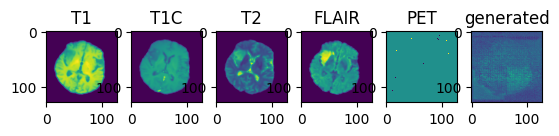

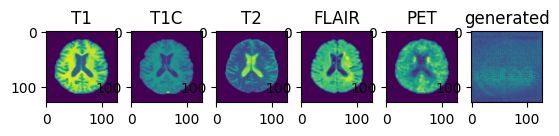

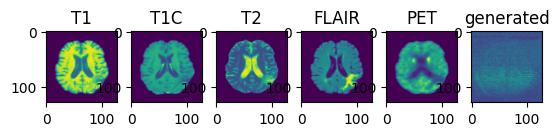

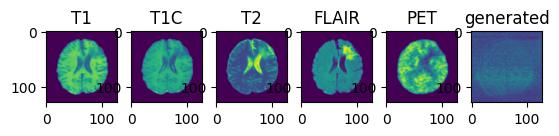

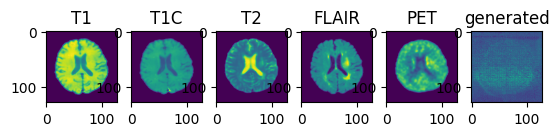

validation avg MS-SSIM: 0.1386 , train avg MS-SSIM: 0.1730
----------
epoch 11/400


Epoch :   0%|                                            | 0/24 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7f673c7f6b00>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7f673c7f6b00>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7f673c7f6b00>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception ignored in: <function _releaseLock at 0x7f673c7f6b00>
Traceback (most recent call last):
  File "/usr/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [ ]:
epoch_loss_values = [(0, 0)]
gen_step_loss = []
disc_step_loss = []
step = 0
max_epochs = 400
disc_train_interval = 1
disc_train_steps = 1
validation_interval = 10
best_ssim = 0.3
c_lambda = 10
torch.cuda.empty_cache()

#Training from scratch, dont need these
#saved_dict = torch.load("./saved_models/experiment9.pth")
#gen_net.load_state_dict(saved_dict['model_state_dict'])

for epoch in range(max_epochs):
    
    gen_net.train()
    disc_net.train()
    epoch_loss = 0

    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")

    for batch_data in tqdm(train_loader, desc=("Epoch ")):
        input_images = torch.cat((batch_data["t1"].to(device, dtype=torch.float), 
                                 batch_data["t1c"].to(device, dtype=torch.float), 
                                 batch_data["t2"].to(device, dtype=torch.float), 
                                 batch_data["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        real_pet = batch_data["pet"].to(device, dtype=torch.float)
        
        gen_images = gen_net(input_images)
        gen_opt.zero_grad()
        loss = generator_loss(gen_images, real_pet)
        loss.backward()
        gen_opt.step()
        epoch_loss += loss.item()
        
        real_pet = real_pet[:,0,:,:,:]
        gen_images = gen_images[:,0,:,:,:]

        gen_step_loss.append((step, loss.item()))

        if step % disc_train_interval == 0:
            disc_total_loss = 0

            for _ in range(disc_train_steps):
                disc_opt.zero_grad()
                
                real_pred = disc_net(real_pet)
                fake_pred = disc_net(gen_images.detach())
                epsilon = torch.rand(len(real_pet), 1, 1, 1, device=device, requires_grad=True)
                gradient = get_gradient(disc_net, real_pet, gen_images.detach(), epsilon)
                gp = gradient_penalty(gradient)
                
                dloss = discriminator_loss(fake_pred, real_pred, gp, c_lambda)
                dloss.backward()
                disc_opt.step()
                disc_total_loss += dloss.item()

            disc_step_loss.append((step, disc_total_loss / disc_train_steps))
        step += 1
    
    epoch_loss /= step
    epoch_loss_values.append((step, epoch_loss))

    if (epoch+1) % validation_interval == 0:
        gen_net.eval()
        slice_index = 32
        ms_ssim = []
        ms_ssim_train = []
        ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)
        
        with torch.no_grad():

            for item in train_metric_loader:
                input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)
                
                generated = gen_net(input_images)
                ms_ssim_train.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))

            curr_ssim_train = torch.mean(torch.FloatTensor(ms_ssim_train))
            
            for item in valid_loader:
                input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

                generated = gen_net(input_images)
        
                image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
                f, axarr = plt.subplots(1, 6)

                ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
                axarr[0].imshow(image_datas[0])
                axarr[0].set_title("T1")
                axarr[1].imshow(image_datas[1])
                axarr[1].set_title("T1C")
                axarr[2].imshow(image_datas[2])
                axarr[2].set_title("T2")
                axarr[3].imshow(image_datas[3])
                axarr[3].set_title("FLAIR")
                axarr[4].imshow(image_datas[4])
                axarr[4].set_title("PET")
                axarr[5].imshow(image_datas[5].cpu())
                axarr[5].set_title("generated")
                plt.show()
                
            curr_ssim = torch.mean(torch.FloatTensor(ms_ssim))

            if curr_ssim > best_ssim:
                best_ssim = curr_ssim
                torch.save({
                        'epoch': epoch,
                        'model_state_dict': gen_net.state_dict(),
                        'optimizer_state_dict': gen_opt.state_dict(),
                        }, "best_metric_glagan.pth")
                
        print("validation avg MS-SSIM: {:.4f} , train avg MS-SSIM: {:.4f}".format(curr_ssim, curr_ssim_train))
            

In [ ]:
plt.figure(figsize=(12, 5))
plt.semilogy(*zip(*gen_step_loss), label="Generator Loss")
plt.semilogy(*zip(*disc_step_loss), label="Discriminator Loss")
plt.grid(True, "both", "both")
plt.legend()

In [ ]:

slice_index = 32

torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_glagan.pth")
gen_net.load_state_dict(saved_dict['model_state_dict'])
gen_net.eval()

ms_ssim = []
ms_ssim_function = monai.metrics.MultiScaleSSIMMetric(spatial_dims = 3, reduction="none", kernel_size=4)

for item in check_DataLoader:

    with torch.no_grad():
        
        input_images = torch.cat((item["t1"].to(device, dtype=torch.float), 
                                     item["t1c"].to(device, dtype=torch.float), 
                                     item["t2"].to(device, dtype=torch.float), 
                                     item["flair"].to(device, dtype=torch.float)), dim=1).to(device)

        generated = gen_net(input_images)
        
        image_datas = item["t1"][0, 0, :, :, slice_index], item["t1c"][0, 0, :, :, slice_index], item["t2"][0, 0, :, :, slice_index], item["flair"][0, 0, :, :, slice_index], item["pet"][0, 0, :, :, slice_index], generated[0, 0, :, :, slice_index] 
                
        f, axarr = plt.subplots(1, 6)

        ms_ssim.append(ms_ssim_function(generated.to(device), item["pet"].to(device)))
                
        axarr[0].imshow(image_datas[0])
        axarr[0].set_title("T1")
        axarr[1].imshow(image_datas[1])
        axarr[1].set_title("T1C")
        axarr[2].imshow(image_datas[2])
        axarr[2].set_title("T2")
        axarr[3].imshow(image_datas[3])
        axarr[3].set_title("FLAIR")
        axarr[4].imshow(image_datas[4])
        axarr[4].set_title("PET")
        axarr[5].imshow(image_datas[5].cpu())
        axarr[5].set_title("generated")
        plt.show()


now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

print("validation avg MS-SSIM: {:.4f} validation avg MSE {:.4f}".format(torch.mean(torch.FloatTensor(ms_ssim)), 0))